In [1]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def chung_lu(degree_seq):
    n = len(degree_seq)
    G = nx.Graph()
    for i in range(n):
        G.add_node(i)
    for i in range(n):
        for j in range(i+1, n):
            prob = degree_seq[i]*degree_seq[j]/(2*(sum(degree_seq)))
            if random.random() < prob:
                G.add_edge(i, j)
    return G

In [3]:
degrees=[7,5,5,4,3,2,2,2,1,1,1,1,1,1,1,1]

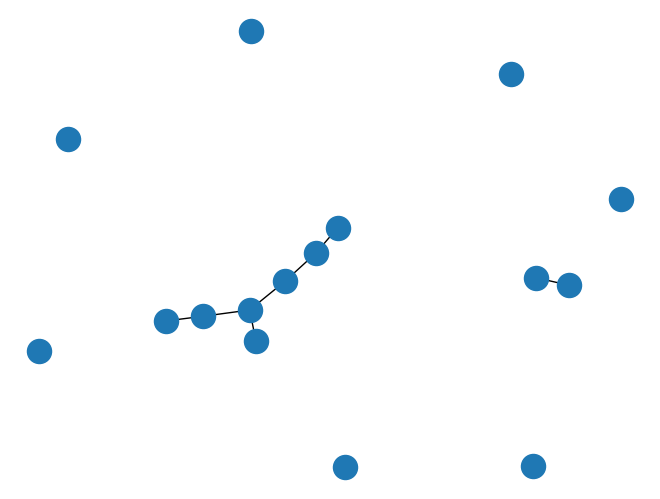

In [34]:
nx.draw(chung_lu(degrees))

In [4]:
def initialize(degree_seq):
    return nx.havel_hakimi_graph(degree_seq)

def pick_double_swap(G):
    edges = list(G.edges())

    edge1, edge2 = random.sample(edges, 2)  

    if len(set(edge1) & set(edge2)) > 0:
        edge1, edge2 = random.sample(edges, 2)
    
     # Get the endpoints of each edge
    a, b = edge1
    c, d = edge2

    # Generate the two possible swaps
    swap1 = [(a,d), (c,b)]
    swap2 = [(a,c), (b,d)]

    # Choose one of the swaps at random
    swap = random.choice([swap1, swap2])

    return swap
    

def is_graph_simple(G):
    """
    Checks whether the given graph is a simple graph (i.e., contains no parallel edges or self-loops).
    Returns True if the graph is simple, False otherwise.
    """
    # Check for parallel edges
    if any(G.has_edge(u, v) and G.has_edge(v, u) for u, v in G.edges()):
        return False

    # Check for self-loops
    if any(u == v for u, v in G.edges()):
        return False

    return True

def apply_swap(G, swap):
    
    # Apply the swap
    new_G = nx.Graph(G)
    new_G.remove_edges_from([swap[0], swap[1]])
    e1 = swap[0][0], swap[1][1]
    e2 = swap[1][0], swap[0][1]
    new_G.add_edges_from([e1, e2])

    if is_graph_simple(new_G):
        return new_G
    else: return G
 
def MCMC(degree_seq):
    G = initialize(degree_seq)
    for _ in range(10):
        swap_edges = pick_double_swap(G)
        G = apply_swap(G, swap_edges)
    return G

In [5]:
test = MCMC(degrees)

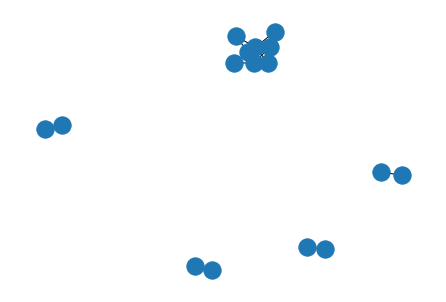

In [6]:
nx.draw(test)

QUESTION 4


In [33]:
def count_edges_between_communities(G, b, community1, community2):
    count = 0
    for node_pair in G.edges():
        node1, node2 = node_pair
        if b[node1] == community1 and b[node2] == community2 or b[node1] == community2 and b[node2] == community1:
            count += 1
    return count

In [34]:
def profile_log_likelihood(G, b):
    n = G.number_of_nodes()
    k = np.array(list(dict(G.degree()).values()))
    L = 0
    community_types = set(b)

    # Iterate over the groups
    for r in community_types:
        nodes_r = np.where(b == r)[0] # get the nodes that are in group r for the degree sum.
        k_r = np.sum(k[nodes_r])

        for s in community_types:
            nodes_s = np.where(b == s)[0]
            k_s = np.sum(k[nodes_s])
            m_rs = count_edges_between_communities(G, b, r, s)

            L += m_rs * np.log(m_rs / (k_s*k_r))

    return L / 2

In [35]:
def init(G):
    b = [0]* len(G.nodes)
    p = 0.5
    for node in range(G.number_of_nodes()):
        if p < random.uniform(0,1):
            b[node] = 1
        else: b[node] = 2
    
    logL = profile_log_likelihood(G, np.array(b))
    return np.array(b), logL

In [398]:
# def optimization(G, b):
#      logL = []
#      sum_logL = profile_log_likelihood(G, np.array(b))
#      logL.append(sum_logL)
#      bPrime = b.copy()
#      freeNodes = set(G.nodes())
#      frozenNodes = set()
#      partition = []
#      partition.append(b)
#      print(b)
     
#      while len(freeNodes) != 0:
#           deltas = {}
#           for node in freeNodes:
#                if b[node] == 1:
#                     bPrime[node] = 2
#                else: bPrime[node] = 1
#                deltas[node] = (profile_log_likelihood(G,bPrime)-profile_log_likelihood(G,b))
               
#           maxDeltaNode = max(deltas, key=deltas.get)
          
#           # update b values
#           if b[maxDeltaNode] == 1:
#                b[maxDeltaNode] = 2
#           else: b[maxDeltaNode] = 1

#           sum_logL += deltas[maxDeltaNode]
#           logL.append(sum_logL)
#           partition.append(b)

#           freeNodes.remove(maxDeltaNode)
#           frozenNodes.add(maxDeltaNode)

#      best_logL_index = np.array(logL).argmax()
#      print("best logL index")
#      print(best_logL_index)
#      best_partition = partition[best_logL_index]
#      print(best_partition)

#      return logL, best_partition, best_logL_index
import random

def optimization(G, b, random_swap_prob=0.1):
    logL = []
    sum_logL = profile_log_likelihood(G, np.array(b))
    logL.append(sum_logL)
    bPrime = b.copy()
    freeNodes = set(G.nodes())
    frozenNodes = set()
    partition = []
    partition.append(b)
    
    while len(freeNodes) != 0:
        deltas = {}
        for node in freeNodes:
            if b[node] == 1:
                bPrime[node] = 2
            else: bPrime[node] = 1
            deltas[node] = (profile_log_likelihood(G,bPrime)-profile_log_likelihood(G,b))
            
        # randomly select a pair of nodes to swap with some probability
        if random.random() < random_swap_prob:
            node1, node2 = random.sample(freeNodes, 2)
        else:
            node1, node2 = max(deltas, key=deltas.get), None
            
        if node2 is None:
            if b[node1] == 1:
                b[node1] = 2
            else: b[node1] = 1
        else:
            if b[node1] == 1:
                b[node1] = 2
                b[node2] = 1
            else:
                b[node1] = 1
                b[node2] = 2

        sum_logL += deltas[node1]
        logL.append(sum_logL)
        partition.append(b)

        freeNodes.remove(node1)
        if node2 is not None:
            freeNodes.remove(node2)
        frozenNodes.add(node1)
        if node2 is not None:
            frozenNodes.add(node2)

    best_logL_index = np.array(logL).argmax()
    print("best logL index")
    print(best_logL_index)
    best_partition = partition[best_logL_index]

    return logL, best_partition, best_logL_index


In [167]:
def load_community_assignments(filename):
    b = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            node, community = line.split('\t')
            b.append(int(community))
    return np.array(b)

def load_graph_from_file(filename):
    G = nx.Graph()
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            node1, node2 = line.split('\t')
            G.add_edge(int(node1) - 1, int(node2) - 1)
    return G

In [12]:
def graph_network(G, b):
    n = G.number_of_nodes()
    color_map = []

    for i in range(n):
        if b[i] == 1:
            color_map.append('red')
        else: 
            color_map.append('blue')    

    nx.draw(G, node_color=color_map)
    plt.show()

In [13]:
# group_file = '/Users/cameronhudson/Documents/Masters/S2/Networks/karate_groups.txt'
# graph_file = '/Users/cameronhudson/Documents/Masters/S2/Networks/karate_edges_77.txt'

group_file = 'karate_groups.txt'
graph_file = 'karate_edges_77.txt'

G = load_graph_from_file(graph_file)
b = load_community_assignments(group_file)

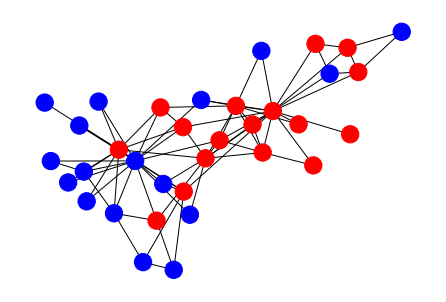

In [18]:
graph_network(G,b)

In [357]:
def run(G, b):
    b, _L = init(G)
    logL, best_partition, best_index = optimization(G, b)
    # logL, partition = optimization(G, best_partition)

    return logL, best_partition, best_index

best logL index
1


C:\Users\alexp\AppData\Local\Temp\ipykernel_21052\1321314925.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  node1, node2 = random.sample(freeNodes, 2)


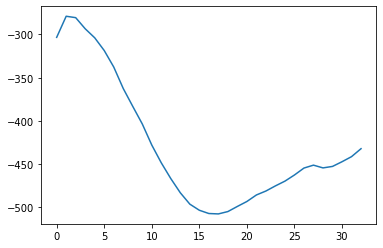

In [403]:
logL, partition, best_index = run(G, b)
plt.plot(logL)


In [430]:
partition

array([1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2])

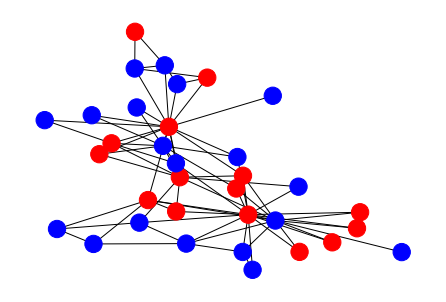

In [429]:
graph_network(G, partition)

In [424]:
def termination(G, b):
    b, _L = init(G)
    logL, best_partition, best_index = optimization(G, b)
    logLs = []
    logLs.append(logL[best_index])
    print("logLs prior:")
    print(logLs)
    count=0
    while True:
        new_logL, new_partition, new_best_index = optimization(G, best_partition)
        count+=1
        # new_logL = profile_log_likelihood(G, new_partition)
        logL+=new_logL
        if new_logL[new_best_index] > logLs[-1]:
            logLs.append(new_logL[new_best_index])
            best_partition = new_partition
        # elif count>4:
        #     break
        else:
            break
    print("logLs:")
    print(logLs)
    return logL, logLs, best_partition


C:\Users\alexp\AppData\Local\Temp\ipykernel_21052\1321314925.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  node1, node2 = random.sample(freeNodes, 2)


best logL index
1
logLs prior:
[-297.5245539376582]
best logL index
32
best logL index
30
best logL index
33
best logL index
32
logLs:
[-297.5245539376582, -203.22311854167913, -104.8813529756921, -60.26698379609263]


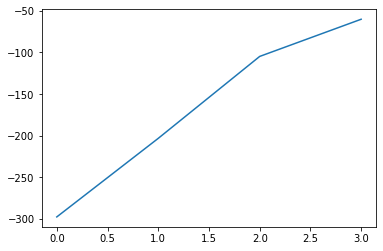

In [425]:
all_logL, logLs, best_partition = termination(G,b)
plt.plot(logLs)




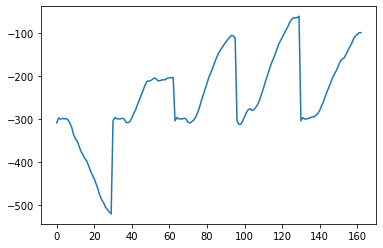

In [428]:

plt.plot(all_logL)

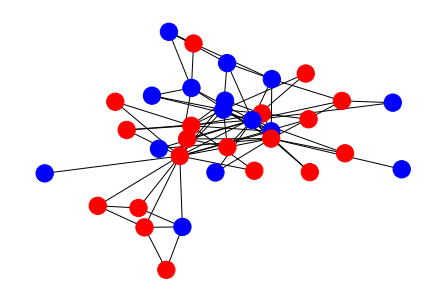

In [427]:
graph_network(G, best_partition)

In [432]:

from sklearn.metrics import adjusted_rand_score

partition1 = [1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
partition2 = [1,1,1,1,1,1,1,1,1,2,1,1,1,1,2,2,1,1,2,1,2,1,2,2,2,2,2,2,2,2,2,2,2,2]

ari = adjusted_rand_score(partition1, partition2)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: -0.027237354085603113
